# Chinatsu
---

<img src="../images/chinatsu.png" style="width: 300px;">

In [240]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
import optuna
import sklearn.datasets
import sklearn.metrics

import math
import os

In [241]:
DATA_DIR = '../data/AAPL/prices.csv'

In [242]:
data = pd.read_csv(DATA_DIR)
data.head()

,Date,Close,Volume,Open,High,Low
0,1361923200000000000,15.8775,586219246,16.0154,16.1586,15.7375
1,1362009600000000000,15.7643,322049711,15.8589,15.9954,15.7643
2,1362096000000000000,15.3739,551278339,15.6429,15.6493,15.3564
3,1362355200000000000,15.0018,577328969,15.2786,15.2929,14.9643
4,1362441600000000000,15.3980,636908185,15.0529,15.5425,15.0268


In [350]:
dataset = data['Close'].values

In [351]:
print(dataset[0:5])
print(dataset.shape)

[15.8775 15.7643 15.3739 15.0018 15.398 ]
(2517,)


In [462]:
TRAIN_SIZE = 0.85
WINDOW_SIZE = 1

In [463]:
train_len = int(len(dataset) * TRAIN_SIZE)
test_len = len(dataset) - train_len
print(f'Train Size: {train_len}, Test Size: {test_len}')

Train Size: 2139, Test Size: 378


In [464]:
train = dataset[0:train_len]
test = dataset[train_len + 1: len(dataset) - 1]

In [465]:
def create_X_y(dataset):
    X = []
    y = []

    for i in range(WINDOW_SIZE, len(dataset)):
        X.append(dataset[(i - WINDOW_SIZE):i])
        y.append(dataset[i])

    return np.array(X), np.array(y)

In [466]:
X_train, y_train = create_X_y(train)

In [467]:
print(X_train.shape)
print(y_train.shape)

(2138, 1)
(2138,)


In [468]:
print(X_train)
print(y_train)

[[ 15.8775]
 [ 15.7643]
 [ 15.3739]
 ...
 [146.7   ]
 [148.19  ]
 [149.71  ]]
[ 15.7643  15.3739  15.0018 ... 148.19   149.71   149.62  ]


In [469]:
X_test, y_test = create_X_y(test)

In [470]:
print(X_test.shape)
print(y_test.shape)

(375, 1)
(375,)


In [290]:
train_data = lgb.Dataset(data=X_train, label=y_train)

In [291]:
def objective(trial):
    param = {
        "objective": "rmse",
        "verbosity": -1,
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "max_depth": trial.suggest_int("max_depth", 10, 200),
        "feature_fraction": 0.8,
    }

    gbm = lgb.train(param, train_data, 100)
    preds = np.expm1(gbm.predict(X_test))
    
    test_mse = np.square(np.subtract(np.expm1(y_test), preds)).mean()
    test_rmse = math.sqrt(test_mse)

    return test_rmse

In [292]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2023-03-01 12:14:13,971] A new study created in memory with name: no-name-19b4642c-5113-4a80-95fa-4f3c6dd7b90d
[I 2023-03-01 12:14:14,722] Trial 0 finished with value: 4.056714627091279 and parameters: {'num_leaves': 171, 'max_depth': 13}. Best is trial 0 with value: 4.056714627091279.
[I 2023-03-01 12:14:15,569] Trial 1 finished with value: 4.04379311380481 and parameters: {'num_leaves': 80, 'max_depth': 52}. Best is trial 1 with value: 4.04379311380481.
[I 2023-03-01 12:14:16,353] Trial 2 finished with value: 4.058167529898736 and parameters: {'num_leaves': 156, 'max_depth': 102}. Best is trial 1 with value: 4.04379311380481.
[I 2023-03-01 12:14:16,833] Trial 3 finished with value: 4.005669442482974 and parameters: {'num_leaves': 56, 'max_depth': 87}. Best is trial 3 with value: 4.005669442482974.
[I 2023-03-01 12:14:17,594] Trial 4 finished with value: 4.058167529898736 and parameters: {'num_leaves': 199, 'max_depth': 157}. Best is trial 3 with value: 4.005669442482974.
[I 2023-0

Number of finished trials: 100
Best trial:
  Value: 3.6694473314073206
  Params: 
    num_leaves: 3
    max_depth: 193


In [301]:
param = {'num_leaves':8, 'max_depth': 160, 'feature_fraction': 0.8, 'verbose': 0, 'learning_rate': 0.06}
param['metric'] = ['rmse']

In [302]:
lgbm = lgb.train(param, train_data, 100)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005101 seconds.
You can set `force_col_wise=true` to remove the overhead.


In [303]:
train_prediction = lgbm.predict(X_train)
train_prediction = np.expm1(train_prediction)
prediction = lgbm.predict(X_test)
prediction = np.expm1(prediction)

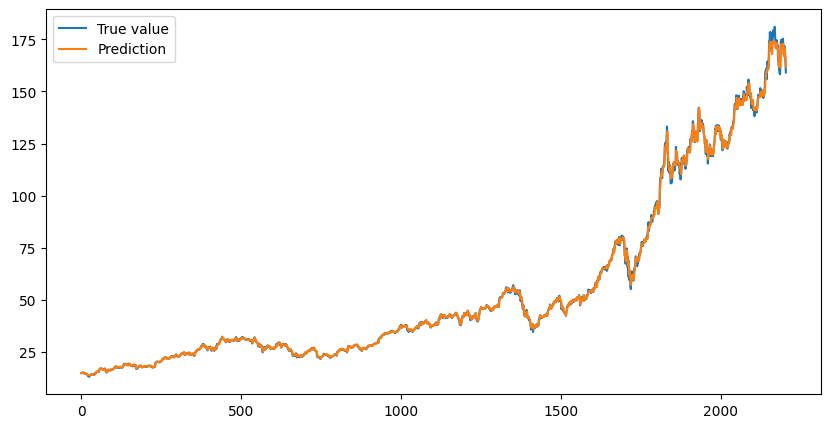

In [304]:
plt.figure(figsize = (10, 5))
plt.plot(np.expm1(y_train), label = "True value")
plt.plot(train_prediction, label = "Prediction")
plt.legend()
plt.show()

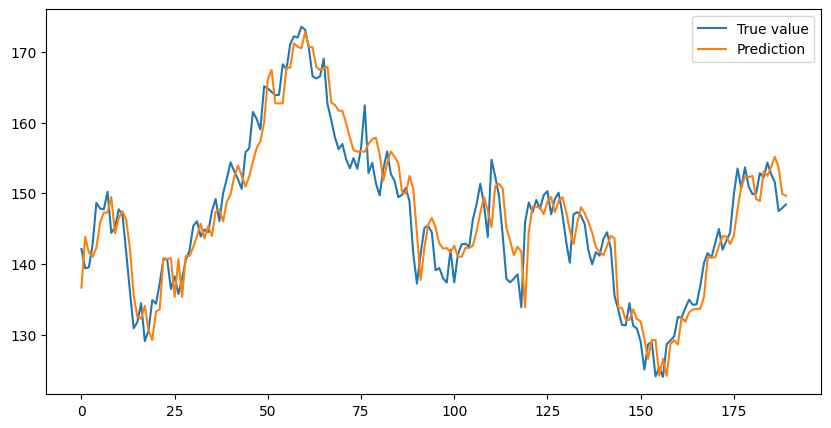

In [305]:
plt.figure(figsize = (10, 5))
plt.plot(np.expm1(y_test), label = "True value")
plt.plot(prediction, label = "Prediction")
plt.legend()
plt.show()

In [306]:
train_mse = np.square(np.subtract(np.expm1(y_train), train_prediction)).mean()
train_rmse = math.sqrt(train_mse)

In [307]:
test_mse = np.square(np.subtract(np.expm1(y_test), prediction)).mean()
test_rmse = math.sqrt(test_mse)

In [308]:
print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')

Train RMSE: 1.1820275789364294
Test RMSE: 3.5547814660042225


In [318]:
random_segment = dataset[69:2400]
X_sample, y_sample = create_X_y(random_segment)

In [319]:
sample_preds = lgbm.predict(X_sample)

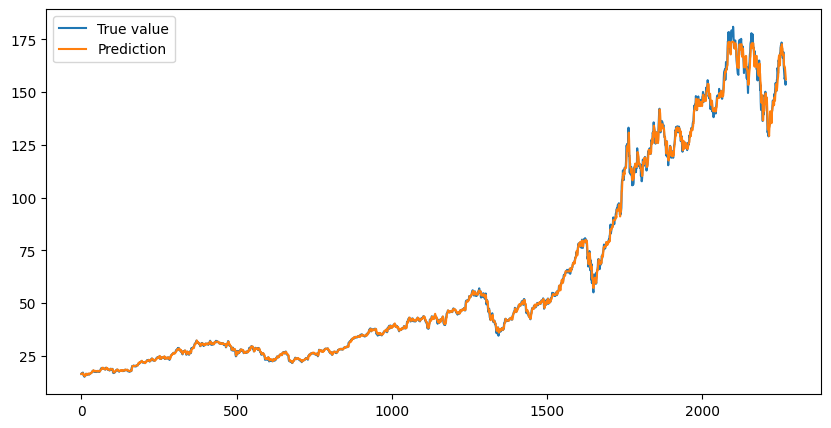

In [320]:
plt.figure(figsize = (10, 5))
plt.plot(np.expm1(y_sample), label = "True value")
plt.plot(np.expm1(sample_preds), label = "Prediction")
plt.legend()
plt.show()